This notebook creates gifs for all of the pre-processing datasets that get created prior to running Ocetrac. Those datasets are:
1. climatology
2. threshold
3. anomaly
4. bolbs/hotwater (combined plot)

Notes
- Climatology/Threshold plots use the same function while Anomaly and Hot Water use a different function. Difference is 1) the bounds vmin/vmax and 2) the a sequential vs. divergent color bar
- `make_matplotlib_plot` and `make_cartopy_plot` do the same thing. I made two different version because I was practicing using the different systems.

In [1]:
import imageio
import os
import glob

import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [ ]:
%matplotlib inline

## Plotting Functions

In [86]:
def make_matplotlib_plot(dataarray, index, title):
    fig = plt.figure()
    fig.patch.set_facecolor('w')

    ax = plt.axes()

    viridis = plt.get_cmap("viridis")
    viridis.set_bad('grey')

    pc = ax.pcolormesh(dataarray.lon, dataarray.lat, dataarray.isel(time=index), 
                       vmin=-2, vmax=30, cmap=viridis, shading='auto')
    cb = fig.colorbar(pc, extend='neither')
    cb.set_label('SST [Celsius]', rotation=270, labelpad=18)

    fig.suptitle(title)
    ax.set_xlabel('Longitude [degrees]')
    ax.set_ylabel('Latitude [degrees]')
    
    return plt

In [58]:
def make_cartopy_plot(dataarray, index, title):
    fig = plt.figure()
    fig.patch.set_facecolor('w')

    ax = plt.axes(projection=ccrs.PlateCarree())
    # Playing with projections
    # ax = plt.axes(projection=ccrs.Stereographic(central_longitude=-60, central_latitude=42))
    ax.coastlines()

    viridis = plt.get_cmap("viridis")
    viridis.set_bad('#ececec')

    pc = ax.pcolormesh(dataarray.lon, dataarray.lat, dataarray.isel(time=index), 
                       vmin=-2, vmax=30, cmap=viridis, shading='auto',
                       transform=ccrs.PlateCarree())
    
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    posn = ax.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.04, posn.height])
    
    cb = fig.colorbar(pc, extend='neither', cax=cbar_ax)
    cb.set_label('SST [Celsius]', rotation=270, labelpad=18)

    full_title = title + ', '+ pd.to_datetime(anomaly.time[index].values).strftime("%Y-%m-%d")
    ax.set_title(full_title, fontsize=13, pad=10)
    
    ax.set_xmargin(0)
    ax.set_ymargin(0)  # Seems like margin is set by default - kwarg in pcolormesh?
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.5)
    gl.top_labels, gl.right_labels = False, False
    y_labels = [35, 40, 45, 50]
    x_labels = [-75, -65, -55, -45]
    gl.xlocator = mticker.FixedLocator(x_labels)
    gl.ylocator = mticker.FixedLocator(y_labels)
    
    return ax

# Climatology

In [34]:
climatology = xr.open_dataset('/data/pacific/rwegener/gulfstream_climatology.nc')
climatology = climatology.climatology

# nan masking
climatology = climatology.where(climatology>0)

# convert to celsius
climatology = climatology - 273.15

Questions/Notes
- why is the plot outline bigger than the data? -- PlateCarree is bad projection?
- color bar sounds like a lot of work to place https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy

<ipython-input-58-4d04aec82785>:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  viridis.set_bad('#ececec')


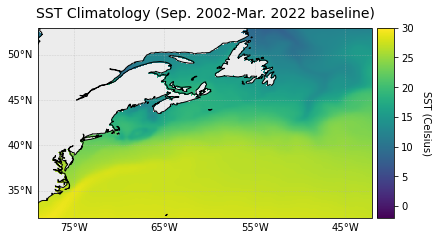

In [59]:
ax = make_cartopy_plot(climatology, 0, 'SST Climatology (Sep. 2002-Mar. 2022 baseline)')
# set_extent can be used instead of set_margin
# ax.set_extent([-78.975, -42.025, 32.025, 52.975], crs=ccrs.PlateCarree())

Docs comments
- set_extent doesn't specify coordinate order (doesn't matter?)
- dms arg of gridlines not documented

<ipython-input-9-707b41a3291f>:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  viridis.set_bad('grey')


<module 'matplotlib.pyplot' from '/homes/metogra/rwegener/.conda/envs/mhw/lib/python3.8/site-packages/matplotlib/pyplot.py'>

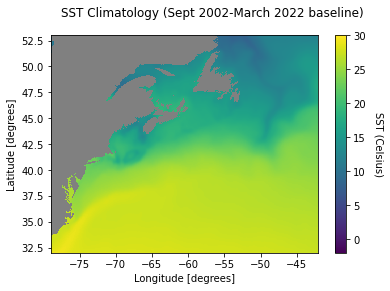

In [10]:
make_matplotlib_plot(climatology, 0, 'SST Climatology (Sept 2002-March 2022 baseline)')

In [99]:
filenames = []
if not os.path.exists('./scratch'):
    os.makedirs('./scratch')

for i in range(len(anomaly.time)):
    fig, ax = make_cartopy_anomaly_plot(anomaly, i, 'SST Anomaly')
    filepath = f"./scratch/{i}.png"
    fig.savefig(filepath, bbox_inches='tight')
    plt.close()
    filenames.append(filepath)

<ipython-input-89-a1849f8210c6>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  viridis.set_bad('#ececec')


In [3]:
# Build GIF
filenames = glob.glob('./scratch/*.png')
with imageio.get_writer('./gulfstream_anomaly.mp4', mode='I', fps=25) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (447, 239) to (448, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# Threshold

In [ ]:
threshold = xr.open_dataset('/data/pacific/rwegener/gulfstream_threshold.nc')
threshold = threshold.threshold

# nan masking
threshold = threshold.where(threshold>0)

# convert to celsius
threshold = threshold - 273.15

In [ ]:
make_matplotlib_plot(threshold, 0, 'MHW Threshold (90th Percentile)')

# Anomaly

In [5]:
anomaly = xr.open_dataset('/data/pacific/rwegener/gulfstream_anomaly.nc')
anomaly = anomaly.anomaly

In [89]:
def make_cartopy_anomaly_plot(dataarray, index, title):
    fig = plt.figure()
    fig.patch.set_facecolor('w')

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    viridis = plt.get_cmap("seismic")
    viridis.set_bad('#ececec')

    pc = ax.pcolormesh(dataarray.lon, dataarray.lat, dataarray.isel(time=index), 
                       vmin=-16.5, vmax=16.5, cmap=viridis, shading='auto',
                       transform=ccrs.PlateCarree())
    
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    posn = ax.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.04, posn.height])
    
    cb = fig.colorbar(pc, extend='neither', cax=cbar_ax)
    cb.set_label('SST [Celsius]', rotation=270, labelpad=18)

    full_title = title + ', '+ pd.to_datetime(anomaly.time[index].values).strftime("%Y-%m-%d")
    ax.set_title(full_title, fontsize=13, pad=10)
    
    ax.set_xmargin(0)
    ax.set_ymargin(0)  # Seems like margin is set by default - kwarg in pcolormesh?
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.5)
    gl.top_labels, gl.right_labels = False, False
    y_labels = [35, 40, 45, 50]
    x_labels = [-75, -65, -55, -45]
    gl.xlocator = mticker.FixedLocator(x_labels)
    gl.ylocator = mticker.FixedLocator(y_labels)
    
    return fig, ax

<ipython-input-89-a1849f8210c6>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  viridis.set_bad('#ececec')


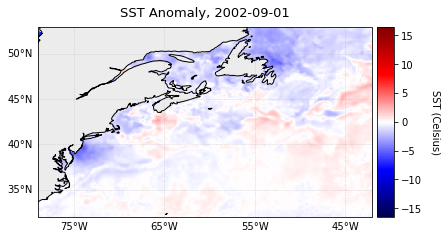

In [90]:
fig, ax = make_cartopy_anomaly_plot(anomaly, 0, 'SST Anomaly')
fig.savefig('scratch.png', bbox_inches='tight')

# Blobs/Hot Water

This section of visualization creates a gif using the Scannell example code for visualizing marine heatwaves. It plots two plots side by side - 1 of the blobs and 1 of the hot water (masked anomaly).

In [1]:
import imageio
import os

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [4]:
blobs = xr.open_dataset('/data/pacific/rwegener/gulfstream_blobs.nc')
blobs = blobs.blobs

In [6]:
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

In [29]:
def ocetrac_plot(index):
    plt.figure(figsize=(16,3))
    ax1 = plt.subplot(121)
    blobs.isel(time=index).plot(cmap=cm, vmin=0, vmax=maxl)
    mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False)
    ax1.set_aspect('equal')
    ax2 = plt.subplot(122)
    hot_water.isel(time=index).plot(cmap='Reds', vmin=0, vmax=16)
    mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False)
    ax2.set_aspect('equal')

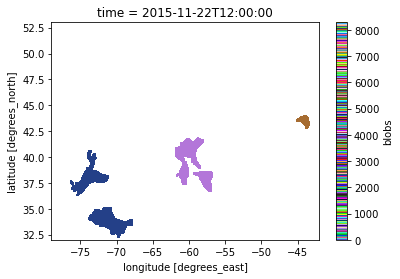

In [33]:
blobs.isel(time=4830).plot(cmap= cm, vmin=0, vmax=maxl)
# mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False)

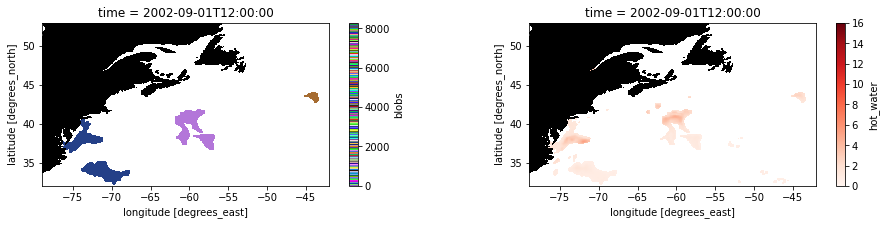

In [30]:
ocetrac_plot(4830)

In [16]:
filenames = []
if not os.path.exists('./scratch'):
    os.makedirs('./scratch')

for i in range(4830, len(blobs.time)):
    ocetrac_plot(i)
    filepath = f"./scratch/{i}.png"
    plt.savefig(filepath, bbox_inches='tight')
    plt.close()
    filenames.append(filepath)

In [21]:
# Build GIF
# TODO create a new list of file names 
filenames = glob.glob('./scratch/*.png')
with imageio.get_writer('./gulfstream_blobs_25fps.mp4', mode='I', fps=25) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (886, 225) to (896, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
